# 매장 판매 예측

## 1. 문제정의 

Rossmann Store 체인점의 2년7개월 판매 데이터를 활용하여 판매량을 에측하는 AI 솔루션을 구축하여 매장의 앞으로의 물건 수요를 확보하여 전체 매장 운영에 필요한 back data를 확보하여 매장 운영 계획을 수립하는데 활용한다. 

## 2. 데이터 확보

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sb

In [2]:
#read_csv를 이용해 데이터 파일 불러오기
train = pd.read_csv('module37/train.csv')
test = pd.read_csv('module37/test.csv')
store = pd.read_csv('module37/store.csv')

C:\Users\hanjo\AppData\Local\Temp\ipykernel_24080\3294753870.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('module37/train.csv')


In [3]:
# StateHoliday column 데이터 숫자,문자 섞여있으므로 모두 문자열로 바꾸어준다.
types = {'StateHoliday': np.dtype(str)}


#전체 train데이터를 사용하고 싶지만,, 컴퓨터 사양으로 인해 1년 동안의 데이터로 슬라이싱
train = train.iloc[:379435,:]

## 3. Data 탐색

### 데이터 전처리

#### 데이터 정보확인

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379435 entries, 0 to 379434
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          379435 non-null  int64 
 1   DayOfWeek      379435 non-null  int64 
 2   Date           379435 non-null  object
 3   Sales          379435 non-null  int64 
 4   Customers      379435 non-null  int64 
 5   Open           379435 non-null  int64 
 6   Promo          379435 non-null  int64 
 7   StateHoliday   379435 non-null  object
 8   SchoolHoliday  379435 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 26.1+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### 결측치 처리

In [7]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [9]:
#결측치 처리 Nan을 0으로
test = test.replace(np.NaN, 0)

In [10]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [11]:
test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [12]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
store = store.replace(np.NaN, 0)

In [14]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


### 그래프그려보기

Train Data에서 각 변수가 Sales에 미치는 영향 파악하기

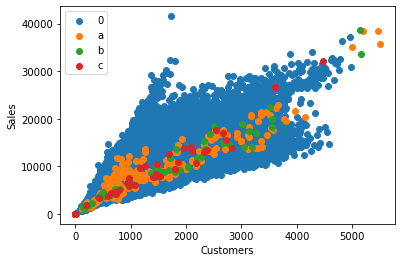

In [15]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)
plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


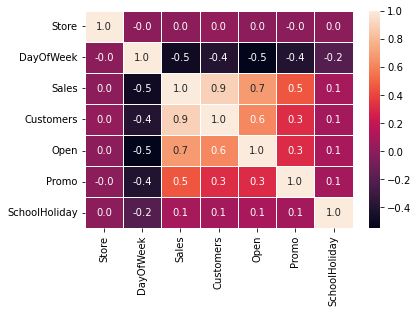

In [16]:
snsplot = sb.heatmap(train.corr(), annot=True,linewidths=0.5, fmt='.1f')

In [18]:
#object type int로 바꿔주는 코드

store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes
train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes


### 매장별 통계 데이터 확인해보기

In [19]:
# df = train["Sales"] / train["Customers"]


In [20]:
# df = pd.DataFrame(df, columns=['spc'])
# df

In [21]:
train['spc'] = train['Sales']/train['Customers']

In [22]:
train.isnull().sum()

Store                0
DayOfWeek            0
Date                 0
Sales                0
Customers            0
Open                 0
Promo                0
StateHoliday         0
SchoolHoliday        0
spc              63895
dtype: int64

In [23]:
train = train.replace(np.NaN, 0)

In [24]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
spc              0
dtype: int64

In [25]:
#grouby 사용하여 각 store의 sales,customers,spc 평균값 만들어 보기 
df = train.groupby('Store')['Sales','Customers','spc'].mean()
df

C:\Users\hanjo\AppData\Local\Temp\ipykernel_24080\4148455785.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = train.groupby('Store')['Sales','Customers','spc'].mean()


,Sales,Customers,spc
Store,,,
1,3880.775342,453.326027,7.062628
2,4212.372603,484.695890,7.170875
3,5741.041096,611.147945,7.665713
4,8323.953425,1114.953425,6.185163
5,3919.868493,442.750685,7.265223
...,...,...,...
1111,4082.389041,344.358904,9.713657
1112,7617.778082,638.504110,9.732728
1113,5690.246575,594.923288,7.936816


In [26]:
#merge 사용하여 앞서 만든 평균값 store에 합치기
store = pd.merge(store, df, on='Store')

In [27]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales,Customers,spc
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",4212.372603,484.695890,7.170875
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",5741.041096,611.147945,7.665713
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0,8323.953425,1114.953425,6.185163
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0,3919.868493,442.750685,7.265223


In [28]:
#merge 사용하여 앞서 만든 store를 train에 합치기
train = pd.merge(train,store, on='Store')
train

,Store,DayOfWeek,Date,Sales_x,Customers_x,Open,Promo,StateHoliday,SchoolHoliday,spc_x,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_y,Customers_y,spc_y
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
1,1,4,2015-07-30,5020,546,1,1,1,1,9.194139,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
2,1,3,2015-07-29,4782,523,1,1,1,1,9.143403,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
3,1,2,2015-07-28,5011,560,1,1,1,1,8.948214,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
4,1,1,2015-07-27,6102,612,1,1,1,1,9.970588,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379430,1115,2,2014-08-05,7028,459,1,1,0,1,15.311547,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603
379431,1115,1,2014-08-04,8457,543,1,1,0,1,15.574586,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603
379432,1115,7,2014-08-03,0,0,0,0,0,1,0.000000,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603
379433,1115,6,2014-08-02,6455,458,1,0,0,1,14.093886,...,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603


In [29]:
#to_datetime 이용해서 object인 데이터타입 datetime으로 바꿔주기
train['Date'] = pd.to_datetime(train['Date'])

In [30]:
train.head()

,Store,DayOfWeek,Date,Sales_x,Customers_x,Open,Promo,StateHoliday,SchoolHoliday,spc_x,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_y,Customers_y,spc_y
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
1,1,4,2015-07-30,5020,546,1,1,1,1,9.194139,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
2,1,3,2015-07-29,4782,523,1,1,1,1,9.143403,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
3,1,2,2015-07-28,5011,560,1,1,1,1,8.948214,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628
4,1,1,2015-07-27,6102,612,1,1,1,1,9.970588,...,1270.0,9.0,2008.0,0,0.0,0.0,0,3880.775342,453.326027,7.062628


In [31]:
import datetime
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['Week'] = train['Date'].dt.week


train

C:\Users\hanjo\AppData\Local\Temp\ipykernel_24080\3130750462.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['Week'] = train['Date'].dt.week


,Store,DayOfWeek,Date,Sales_x,Customers_x,Open,Promo,StateHoliday,SchoolHoliday,spc_x,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_y,Customers_y,spc_y,Year,Month,Day,Week
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,0.0,0.0,0,3880.775342,453.326027,7.062628,2015,7,31,31
1,1,4,2015-07-30,5020,546,1,1,1,1,9.194139,...,0.0,0.0,0,3880.775342,453.326027,7.062628,2015,7,30,31
2,1,3,2015-07-29,4782,523,1,1,1,1,9.143403,...,0.0,0.0,0,3880.775342,453.326027,7.062628,2015,7,29,31
3,1,2,2015-07-28,5011,560,1,1,1,1,8.948214,...,0.0,0.0,0,3880.775342,453.326027,7.062628,2015,7,28,31
4,1,1,2015-07-27,6102,612,1,1,1,1,9.970588,...,0.0,0.0,0,3880.775342,453.326027,7.062628,2015,7,27,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379430,1115,2,2014-08-05,7028,459,1,1,0,1,15.311547,...,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,5,32
379431,1115,1,2014-08-04,8457,543,1,1,0,1,15.574586,...,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,4,32
379432,1115,7,2014-08-03,0,0,0,0,0,1,0.000000,...,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,3,31
379433,1115,6,2014-08-02,6455,458,1,0,0,1,14.093886,...,22.0,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,2,31


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379435 entries, 0 to 379434
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      379435 non-null  int64         
 1   DayOfWeek                  379435 non-null  int64         
 2   Date                       379435 non-null  datetime64[ns]
 3   Sales_x                    379435 non-null  int64         
 4   Customers_x                379435 non-null  int64         
 5   Open                       379435 non-null  int64         
 6   Promo                      379435 non-null  int64         
 7   StateHoliday               379435 non-null  int8          
 8   SchoolHoliday              379435 non-null  int64         
 9   spc_x                      379435 non-null  float64       
 10  StoreType                  379435 non-null  int8          
 11  Assortment                 379435 non-null  int8    

In [34]:
 # 경쟁이 존재한 개월 수
train['MonthsCompetitionOpen'] = 12 * (train['Year'] - train['CompetitionOpenSinceYear']) + (train['Month'] - train['CompetitionOpenSinceMonth'])
train

,Store,DayOfWeek,Date,Sales_x,Customers_x,Open,Promo,StateHoliday,SchoolHoliday,spc_x,...,Promo2SinceYear,PromoInterval,Sales_y,Customers_y,spc_y,Year,Month,Day,Week,MonthsCompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,0.0,0,3880.775342,453.326027,7.062628,2015,7,31,31,82.0
1,1,4,2015-07-30,5020,546,1,1,1,1,9.194139,...,0.0,0,3880.775342,453.326027,7.062628,2015,7,30,31,82.0
2,1,3,2015-07-29,4782,523,1,1,1,1,9.143403,...,0.0,0,3880.775342,453.326027,7.062628,2015,7,29,31,82.0
3,1,2,2015-07-28,5011,560,1,1,1,1,8.948214,...,0.0,0,3880.775342,453.326027,7.062628,2015,7,28,31,82.0
4,1,1,2015-07-27,6102,612,1,1,1,1,9.970588,...,0.0,0,3880.775342,453.326027,7.062628,2015,7,27,31,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379430,1115,2,2014-08-05,7028,459,1,1,0,1,15.311547,...,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,5,32,24176.0
379431,1115,1,2014-08-04,8457,543,1,1,0,1,15.574586,...,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,4,32,24176.0
379432,1115,7,2014-08-03,0,0,0,0,0,1,0.000000,...,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,3,31,24176.0
379433,1115,6,2014-08-02,6455,458,1,0,0,1,14.093886,...,2012.0,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,2,31,24176.0


In [35]:
 # 프로모션이 존재한 주 수
train['WeeksPromoOpen'] = 12 * (train['Year'] - train['Promo2SinceYear']) + (train['Date'].dt.weekofyear - train['Promo2SinceWeek'])

train

C:\Users\hanjo\AppData\Local\Temp\ipykernel_24080\3038397542.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['WeeksPromoOpen'] = 12 * (train['Year'] - train['Promo2SinceYear']) + (train['Date'].dt.weekofyear - train['Promo2SinceWeek'])


,Store,DayOfWeek,Date,Sales_x,Customers_x,Open,Promo,StateHoliday,SchoolHoliday,spc_x,...,PromoInterval,Sales_y,Customers_y,spc_y,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-07-31,5263,555,1,1,1,1,9.482883,...,0,3880.775342,453.326027,7.062628,2015,7,31,31,82.0,24211.0
1,1,4,2015-07-30,5020,546,1,1,1,1,9.194139,...,0,3880.775342,453.326027,7.062628,2015,7,30,31,82.0,24211.0
2,1,3,2015-07-29,4782,523,1,1,1,1,9.143403,...,0,3880.775342,453.326027,7.062628,2015,7,29,31,82.0,24211.0
3,1,2,2015-07-28,5011,560,1,1,1,1,8.948214,...,0,3880.775342,453.326027,7.062628,2015,7,28,31,82.0,24211.0
4,1,1,2015-07-27,6102,612,1,1,1,1,9.970588,...,0,3880.775342,453.326027,7.062628,2015,7,27,31,82.0,24211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379430,1115,2,2014-08-05,7028,459,1,1,0,1,15.311547,...,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,5,32,24176.0,34.0
379431,1115,1,2014-08-04,8457,543,1,1,0,1,15.574586,...,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,4,32,24176.0,34.0
379432,1115,7,2014-08-03,0,0,0,0,0,1,0.000000,...,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,3,31,24176.0,33.0
379433,1115,6,2014-08-02,6455,458,1,0,0,1,14.093886,...,"Mar,Jun,Sept,Dec",5821.553425,391.495890,12.235603,2014,8,2,31,24176.0,33.0


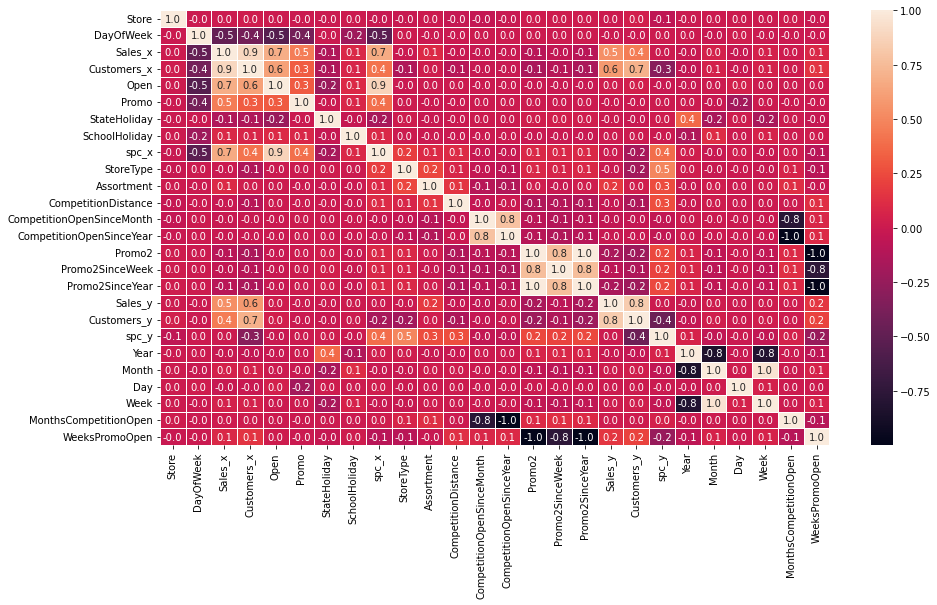

In [36]:
plt.figure(figsize = (15,8))
snsplot = sb.heatmap(train.corr(), annot=True,linewidths=0.5, fmt='.1f')

In [37]:
print(abs(train.corr()['Sales_x']).sort_values(ascending=False))

Sales_x                      1.000000
Customers_x                  0.891396
Open                         0.684605
spc_x                        0.665388
Sales_y                      0.537798
DayOfWeek                    0.481223
Promo                        0.453943
Customers_y                  0.449284
StateHoliday                 0.126423
Assortment                   0.095325
SchoolHoliday                0.092340
WeeksPromoOpen               0.086771
Promo2SinceYear              0.086754
Promo2                       0.086741
Week                         0.050152
Month                        0.047784
Promo2SinceWeek              0.041358
Year                         0.023408
CompetitionOpenSinceMonth    0.022748
Day                          0.020596
CompetitionDistance          0.014710
MonthsCompetitionOpen        0.008668
CompetitionOpenSinceYear     0.008660
Store                        0.002463
spc_y                        0.002346
StoreType                    0.001212
Name: Sales_

### Train, Test 데이터셋 분할

In [38]:
# test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [44]:
features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','Year','Month','Day','Week']


X = train[features]
y = train['Sales_x']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 4. 모델링

### Helper 함수 

In [46]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    # reg_metrics 반환
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

In [47]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


### Linear Regression

In [48]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn import model_selection 
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier, export_graphviz
from sklearn import metrics 
from sklearn.feature_selection import SelectFromModel, RFECV


linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics

R^2 training: 0.561, R^2 test: 0.562


,Linear Regression
Root Mean Squared Error,2581.777262
Mean Absolute Error,1803.803149
R^2,0.562194
Explained Variance,0.562198


### Lasso

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import numpy as np


lasso_alpha = 0.1
lasso = Lasso(alpha = lasso_alpha)

lasso.fit(X_train,y_train)

y_test_predict = lasso.predict(X_test)
y_train_predict = lasso.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

lasso_metrics = get_regression_metrics('Lasso', y_test, y_test_predict)
lasso_metrics

R^2 training: 0.561, R^2 test: 0.562


C:\Users\hanjo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.283e+11, tolerance: 4.068e+08
  model = cd_fast.enet_coordinate_descent(


,Lasso
Root Mean Squared Error,2582.030944
Mean Absolute Error,1804.171268
R^2,0.562108
Explained Variance,0.562112


### Ridge

In [50]:
ridge_alpha = 1

ridge = Ridge(alpha = ridge_alpha)

ridge.fit(X_train,y_train)

y_test_predict = ridge.predict(X_test)
y_train_predict = ridge.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

ridge_metrics = get_regression_metrics('Ridge', y_test, y_test_predict)
ridge_metrics

R^2 training: 0.561, R^2 test: 0.562


,Ridge
Root Mean Squared Error,2581.999488
Mean Absolute Error,1804.157675
R^2,0.562119
Explained Variance,0.562123


### RandomForest

In [51]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

y_test_predict = rfr.predict(X_test)
y_train_predict = rfr.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rfr_metrics = get_regression_metrics('RandomForest', y_test, y_test_predict)
rfr_metrics

R^2 training: 0.992, R^2 test: 0.945


,RandomForest
Root Mean Squared Error,919.191090
Mean Absolute Error,529.048888
R^2,0.944505
Explained Variance,0.944508


RandomForest모델의 RMSE: 919.19, R^2 test: 0.945로 성능이 제일 좋았다. test 데이터를 RandomForest모델을 사용하여 예측해보겠다.

## 5. test 데이터셋에 모델 적용하기

test데이터를 모델에 적용하기 위해 store를 merge시켜 학습 시 train 데이터와 같은 colmuns를 만들어 준다. 

In [86]:
test = pd.read_csv('module37/test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [87]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [88]:
test.fillna(0, inplace=True)

In [89]:
store2 = pd.read_csv('module37/store.csv')
store2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [91]:
store2.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [90]:
store2.fillna(0, inplace=True)

In [92]:
test = pd.merge(test,store2, on='Store')
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,3,2015-08-05,1.0,1,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41084,38520,1115,2,2015-08-04,1.0,1,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41085,39376,1115,1,2015-08-03,1.0,1,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41086,40232,1115,7,2015-08-02,0.0,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [93]:
test['Date'] = pd.to_datetime(test['Date'])

In [94]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         41088 non-null  int64         
 1   Store                      41088 non-null  int64         
 2   DayOfWeek                  41088 non-null  int64         
 3   Date                       41088 non-null  datetime64[ns]
 4   Open                       41088 non-null  float64       
 5   Promo                      41088 non-null  int64         
 6   StateHoliday               41088 non-null  object        
 7   SchoolHoliday              41088 non-null  int64         
 8   StoreType                  41088 non-null  object        
 9   Assortment                 41088 non-null  object        
 10  CompetitionDistance        41088 non-null  float64       
 11  CompetitionOpenSinceMonth  41088 non-null  float64       
 12  Comp

In [95]:
test['StoreType'] = test['StoreType'].astype('category').cat.codes
test['Assortment'] = test['Assortment'].astype('category').cat.codes
test["StateHoliday"] = test["StateHoliday"].astype('category').cat.codes


In [96]:
import datetime
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['Week'] = test['Date'].dt.week

test

C:\Users\hanjo\AppData\Local\Temp\ipykernel_24080\4021810321.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['Week'] = test['Date'].dt.week


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week
0,1,1,4,2015-09-17,1.0,1,0,0,2,0,...,9.0,2008.0,0,0.0,0.0,0,2015,9,17,38
1,857,1,3,2015-09-16,1.0,1,0,0,2,0,...,9.0,2008.0,0,0.0,0.0,0,2015,9,16,38
2,1713,1,2,2015-09-15,1.0,1,0,0,2,0,...,9.0,2008.0,0,0.0,0.0,0,2015,9,15,38
3,2569,1,1,2015-09-14,1.0,1,0,0,2,0,...,9.0,2008.0,0,0.0,0.0,0,2015,9,14,38
4,3425,1,7,2015-09-13,0.0,0,0,0,2,0,...,9.0,2008.0,0,0.0,0.0,0,2015,9,13,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,3,2015-08-05,1.0,1,0,1,3,2,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,5,32
41084,38520,1115,2,2015-08-04,1.0,1,0,1,3,2,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,4,32
41085,39376,1115,1,2015-08-03,1.0,1,0,1,3,2,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,3,32
41086,40232,1115,7,2015-08-02,0.0,0,0,1,3,2,...,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,2,31


In [97]:
test = test.drop(columns = ['Date','Id','PromoInterval'], axis=1)

In [98]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      41088 non-null  int64  
 1   DayOfWeek                  41088 non-null  int64  
 2   Open                       41088 non-null  float64
 3   Promo                      41088 non-null  int64  
 4   StateHoliday               41088 non-null  int8   
 5   SchoolHoliday              41088 non-null  int64  
 6   StoreType                  41088 non-null  int8   
 7   Assortment                 41088 non-null  int8   
 8   CompetitionDistance        41088 non-null  float64
 9   CompetitionOpenSinceMonth  41088 non-null  float64
 10  CompetitionOpenSinceYear   41088 non-null  float64
 11  Promo2                     41088 non-null  int64  
 12  Promo2SinceWeek            41088 non-null  float64
 13  Promo2SinceYear            41088 non-null  flo

In [99]:
y_pred = rfr.predict(test)

In [100]:
print(y_pred)

[4091.41 4329.86 5105.95 ... 9395.78    0.   6709.15]


In [101]:
type(y_pred)

numpy.ndarray

In [102]:
predict = pd.read_csv('module37/test.csv')
predict

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [103]:
predict['Sales'] = pd.DataFrame(y_pred)

In [104]:
Submission = predict[['Id','Sales']]


In [105]:
Submission

,Id,Sales
0,1,4091.41
1,2,4329.86
2,3,5105.95
3,4,5037.61
4,5,0.00
...,...,...
41083,41084,6747.43
41084,41085,6988.53
41085,41086,9395.78
41086,41087,0.00


In [106]:
#예측 판매량 csv파일으로 변환하기
Submission.to_csv('Submission_한가희.csv', index=False)

제일 처음 test 데이터를 randomforest 모델로 예측할 때 학습시킨 train feature와 test feature가 일치해야한다는 것을 몰라서 헤맸었다. 그래서 처음 학습할 땐 test 데이터에만 있는 컬럼으로 feature값을 지정해 학습시켰고 RandomForest 모델의 RMSE가 1167.794357로 나왔다. 후에 Store 데이터를 merge시켜 컬럼을 추가하여 진행하였을 때 RMSE가 919.191090로 감소한 것을 볼 수 있다. 처음보다 성능이 더 좋은 모델을 만들어보았다.